### Config & Importing Libraries

In [1]:
import numpy as np
import torch
import torch.linalg as linalg
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib import rcParams,colormaps
import shutil
import matplotlib.animation as animation

# Configuration for making plots
fig_width = 8
fig_height = fig_width/1.62
params = {
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'figure.figsize': [fig_width,fig_height],
    'font.family': 'serif',
    'figure.autolayout': True       # tight layout
    }

rcParams.update(params)

# Tex might not be installed
rcParams['text.usetex'] = True if shutil.which('latex') else False
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

default_type = np.float64

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


### Generate Data

In [2]:
np.random.seed(45)
num_samples = 40
    
# Generate data
x1 = np.random.uniform(-1, 1, num_samples).astype(default_type)
f_x = 3*x1 + 4

eps = np.random.randn(num_samples).astype(default_type)
Y = f_x + eps

Y = torch.from_numpy(Y)
Y.requires_grad_(False)

# We move our tensor to the GPU if available
if torch.cuda.is_available():
    x1 = x1.to("cuda")
    Y = Y.to("cuda")

### Implementations

In [21]:
# Produce new theta tensor from seed
def new_theta(seed=25):
    np.random.seed(seed)
    _theta = torch.from_numpy(np.random.standard_normal(2).T.astype(default_type))
    _theta.requires_grad_(True)
    _theta.grad = None
    return _theta


# for 1D tensor Y, (Y.T @ Y) is equivalent to (Y @ Y)
mse_loss = lambda X,Y,theta: ((Y @ Y) + ((theta @ X.mT ) - 2*(Y)) @ X @ theta)/num_samples


sgd_loss = lambda x,y_,theta: (y_**2 +(x @ theta)*((x @ theta) - 2*y_))


# Full Batch Gradient Descent
def full_batch(theta,epochs,min_loss=None,momentum=0):
    '''
    theta : theta vector
    epochs : maximum epochs to run
    min_loss: min loss at which the function will stop iterating
    momentum: momentum coefficient
    '''

    full_batch_losses = []
    thetas = []
    change = torch.tensor([0,0],dtype=theta.dtype)
    iterations = 0

    for epoch in range(epochs):

        iterations += 1
        loss = mse_loss(X,Y,theta)

        theta.grad = None
        loss.backward()

        thetas.append(theta.detach().clone().numpy().astype(default_type))
        full_batch_losses.append(loss.item())

        change = a*theta.grad + momentum*change

        with torch.no_grad():
            theta -= change

        if (min_loss is not None) and full_batch_losses[epoch]<min_loss:
                return np.array(thetas), full_batch_losses, iterations
        
    return np.array(thetas), full_batch_losses, iterations




# Mini Batch Gradient Descent
def mini_batch(theta,epochs, min_loss = None,batch_size = 10,momentum=0):
    '''
    theta : theta vector
    epochs : maximum epochs to run
    min_loss: min loss at which the function will stop iterating
    momentum: momentum coefficient
    '''
    
    mini_batch_losses = []
    thetas = []
    change = torch.tensor([0,0],dtype=theta.dtype)
    iterations = 0

    for epoch in range(epochs):
        permutation = torch.randperm(X.size()[0])

        loss = mse_loss(X,Y,theta)
        mini_batch_losses.append(loss.item())
        thetas.append(theta.detach().clone().numpy().astype(default_type))

        if (min_loss is not None) and mini_batch_losses[epoch]<min_loss:
            return np.array(thetas), mini_batch_losses, iterations

        for i in range(0,X.size()[0],batch_size):
            
            iterations+=1
            indices = permutation[i:i+batch_size]
            batch_X, batch_y = X[indices], Y[indices]

            loss = mse_loss(batch_X, batch_y, theta)

            theta.grad = None
            loss.backward()

            change = a*theta.grad + momentum*change

            with torch.no_grad():
                theta -= change

    return np.array(thetas), mini_batch_losses, iterations


# Stochastic Gradient Descent
def sgd(theta,epochs,min_loss=None,momentum=0):
    sgd_losses = []
    thetas = []
    iterations = 0
    change = torch.tensor([0,0],dtype=theta.dtype)

    for epoch in range(epochs):
        
        loss = mse_loss(X,Y,theta)
        sgd_losses.append(loss.item())
        thetas.append(theta.detach().clone().numpy().astype(default_type))

        if (min_loss is not None) and sgd_losses[epoch]<min_loss:
            return np.array(thetas), sgd_losses, iterations
        
        permutation = torch.randperm(X.size()[0])

        for i in range(num_samples):
            iterations += 1
            loss = sgd_loss(X[permutation[i]],Y[permutation[i]],theta)
            
            theta.grad = None
            loss.backward()
            
            change = a*theta.grad + momentum*change
            
            with torch.no_grad():
                theta -= change
            
    return np.array(thetas), sgd_losses, iterations


gdf = [full_batch,mini_batch,sgd]

In [28]:
text = ["Full Batch GD","Mini Batch GD","Stochastic GD"]
colors = ['orange','darkblue','green']
ls = ['-','-.','-']         # Line styles

# Matrix X of shape 2xN
X = torch.vstack((torch.ones(x1.shape),torch.from_numpy(x1))).mT

opt_theta = linalg.solve( X.mT @ X , X.mT @ Y)   # faster and numerically stable than than (linalg.inv(X.mT@X) @ (X.mT @ Y))
print("Optimal theta:",opt_theta)

opt_loss = mse_loss(X,Y,opt_theta).item()
print("Optimal loss:",opt_loss)

epsilon = 0.001
a = 0.01
num_iters = 15
epochs_for_avg_iter = 1000
max_epochs = 15
momentum = 0.9

min_loss = opt_loss + epsilon
print("Min loss to achieve:",min_loss)

Optimal theta: tensor([3.9507, 2.6825], dtype=torch.float64)
Optimal loss: 0.5957541565733294
Min loss to achieve: 0.5967541565733294


### True Gradient for random $\theta$

theta: tensor([0.2283, 1.0269], dtype=torch.float64, requires_grad=True)
true gradient for above theta: tensor([-7.1644, -0.4153], dtype=torch.float64)


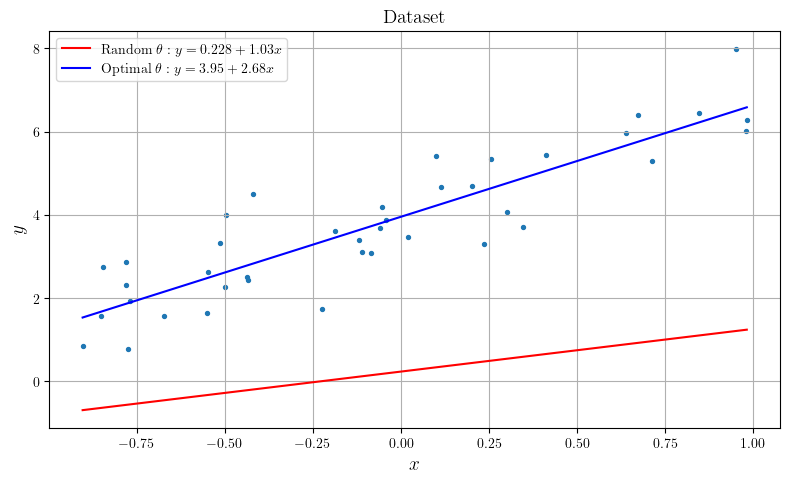

In [5]:

theta = new_theta()     # seed defaults to 25
print("theta:",theta)

mse_loss(X,Y,theta).backward()
true_grad = theta.grad

print("true gradient for above theta:",true_grad)

fig, ax = plt.subplots()

ax.scatter(X[:,1].detach(),Y.detach(),s=8)

ax.plot(
    [min(x1),max(x1)],
    [min(x1)*theta[1].item()+theta[0].item(),max(x1)*theta[1].item()+theta[0].item()],
    'r-',
    label=f"Random $\\theta: y={theta[0].item():<.3}+{theta[1].item():<.3}x$"
    )

ax.plot(
    [min(x1),max(x1)],
    [min(x1)*opt_theta[1].item()+opt_theta[0].item(),max(x1)*opt_theta[1].item()+opt_theta[0].item()],
    'b-',
    label=f"Optimal $\\theta: y={opt_theta[0].item():<.3}+{opt_theta[1].item():<.3}x$"
    )

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Dataset")
plt.legend()
plt.grid()
plt.show()

### Average of Stochastic Gradients

In [6]:
sum_grad = 0

for j in range(num_samples):
    theta.grad = None       # to reset theta.grad otherwise gradient will be accumulated
    y_ = Y[j]
    x = X[j]
    sgd_loss(x,y_,theta).backward()
    sum_grad += theta.grad

avg_grad = sum_grad/num_samples
print("Avg gradient:",avg_grad)

assert torch.allclose(avg_grad,true_grad), "Something is wrong"

Avg gradient: tensor([-7.1644, -0.4153], dtype=torch.float64)


### Average number of Iterations

In [43]:
avg_n_iters0 = [0,0,0]

for i in range(num_iters):
    seed = np.random.randint(0,1e7)
    random_thetas = []

    for j in range(3):
        random_thetas.append(new_theta(seed))
        thetas, losses, iters = gdf[j](random_thetas[j],epochs_for_avg_iter,min_loss=min_loss)
        avg_n_iters0[j] += iters/num_iters

for i in range(3):
    print(f"{text[i]} avg iterations: {avg_n_iters0[i]:>10.2f}")

Full Batch GD avg iterations:     624.13
Mini Batch GD avg iterations:    2497.07
Stochastic GD avg iterations:     648.00


### Graph of Loss vs Epochs

In [8]:

seed0 = np.random.randint(0,1e7)        # this seed will be used again for gradient descent with momentum

print("Seed:",seed0)
print("Learning Rate:",a)
print("Number of Epochs:",max_epochs)

thetas_gdf0 = []
losses_gdf0 = []

for j in range(3):
    thetas, losses, iters = gdf[j](new_theta(seed0),max_epochs)
    thetas_gdf0.append(thetas)
    losses_gdf0.append(losses)

Seed: 3142583
Learning Rate: 0.01
Number of Epochs: 15


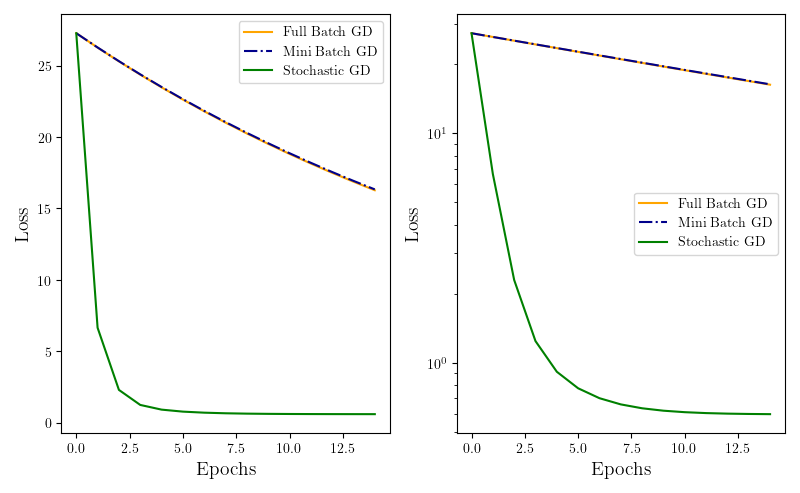

In [41]:
fig, ax = plt.subplots(1,2)

for j in range(2):
    for i in range(3):
        ax[j].plot(losses_gdf0[i],label=text[i],c=colors[i],ls=ls[i])
    ax[j].set_xlabel("Epochs")
    ax[j].set_ylabel("Loss")
    ax[j].legend()

ax[1].set_yscale('log')

plt.show()

### Contour Plot animation for Loss

In [10]:
# meshgrid for contour plots
min_theta_x = np.min(thetas_gdf0[2][:,0])-1
max_theta_x = np.max(thetas_gdf0[2][:,0])+1
min_theta_y = np.min(thetas_gdf0[2][:,1])-1
max_theta_y = np.max(thetas_gdf0[2][:,1])+2

x, y = np.meshgrid(np.arange(min_theta_x,max_theta_x,0.05).astype(default_type),np.arange(min_theta_y,max_theta_y,0.05).astype(default_type))
z = np.zeros_like(x)

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i][j] = (mse_loss(X,Y,torch.tensor([x[i][j],y[i][j]])))

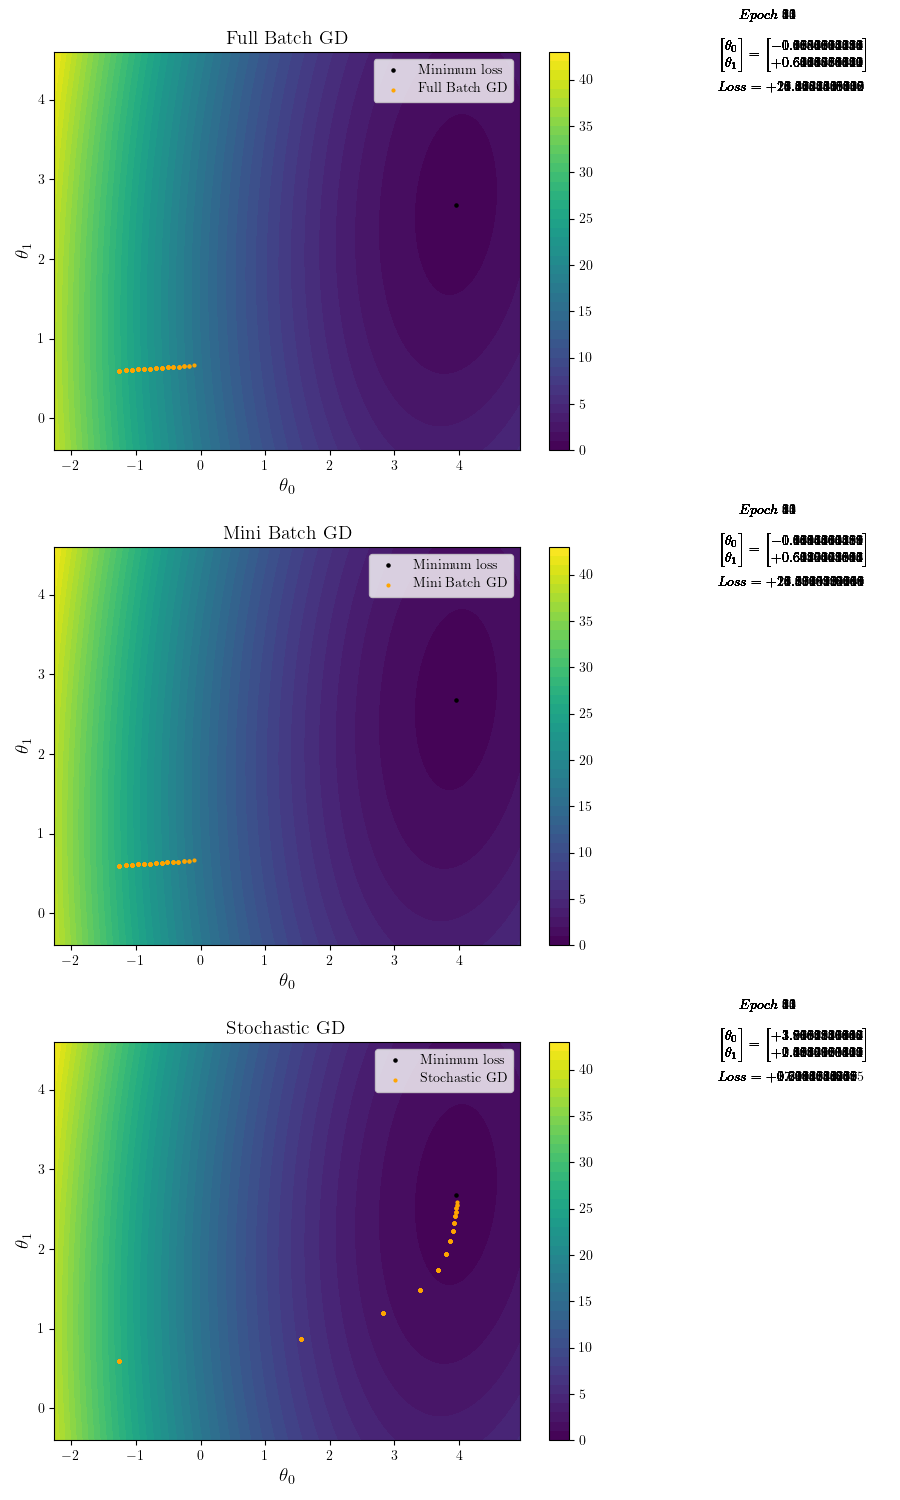

In [11]:
%matplotlib widget

artists = []
ans = []

fig, ax = plt.subplots(3,1,figsize=(9,15))

for i in range(3):
    cs = ax[i].contourf(x,y,z,50,cmap=colormaps['viridis'])
    plt.colorbar(cs)
    ax[i].set(title=text[i],xlabel="$\\theta_0$",ylabel="$\\theta_1$")
    ax[i].scatter(opt_theta[0].item(),opt_theta[1].item(),c='k',s=5,label="Minimum loss")
    ax[i].scatter([],[],c ='orange',s=4,label=text[i])
    ax[i].legend()
    artists.append([])

    for j in range(len(thetas_gdf0[i])):

        artists[i].append([
            ax[i].scatter(thetas_gdf0[i][:j,0],thetas_gdf0[i][:j,1],c ='orange',s=4),

            ax[i].text(8,5,
            fr"""$Epoch\ {j+1} \\ \\ \begin{{bmatrix}} \theta_0 \\ \theta_1\end{{bmatrix}} = \begin{{bmatrix}}{thetas_gdf0[i][j,0]:<+5.10f}\\{thetas_gdf0[i][j,1]:<+5.10f}\end{{bmatrix}}\\ \\ Loss = {losses_gdf0[i][j]:+5.10f}$"""
            )])

    ans.append(animation.ArtistAnimation(fig=fig, artists=artists[i], interval=500,repeat=True))

plt.show()

In [42]:
avg_n_iters1 = [0,0,0]

for i in range(num_iters):
    seed = np.random.randint(0,1e7)
    random_thetas = []

    for j in range(3):
        random_thetas.append(new_theta(seed))
        thetas, losses, iters = gdf[j](random_thetas[j],epochs_for_avg_iter,min_loss=min_loss,momentum=momentum)
        avg_n_iters1[j] += iters/num_iters

for i in range(3):
    print(f"{text[i]} avg iterations: {avg_n_iters1[i]:>10.2f}")

Full Batch GD avg iterations:      38.00
Mini Batch GD avg iterations:     234.13
Stochastic GD avg iterations:    1330.67


In [32]:
print("----For gradient descent with momentum")
for i in range(3):
    print(f"{text[i]} avg iterations: {avg_n_iters1[i]:>10.2f}")

print()
print("----For gradient descent without momentum")
for i in range(3):
    print(f"{text[i]} avg iterations: {avg_n_iters0[i]:>10.2f}")

----For gradient descent with momentum
Full Batch GD avg iterations:      38.00
Mini Batch GD avg iterations:     230.93
Stochastic GD avg iterations:    1213.33

----For gradient descent without momentum
Full Batch GD avg iterations:     643.93
Mini Batch GD avg iterations:    2577.07
Stochastic GD avg iterations:     674.67


As it is evident from the above output that Gradient descent with momentum is faster than method without momentum for Full batch and Mini Batch gradient descent.

In [33]:
thetas_gdf1 = []
losses_gdf1 = []

print("Seed",seed0)

for j in range(3):
    thetas, losses, iters = gdf[j](new_theta(seed0),max_epochs,momentum=momentum)
    thetas_gdf1.append(thetas)
    losses_gdf1.append(losses)

Seed 3142583


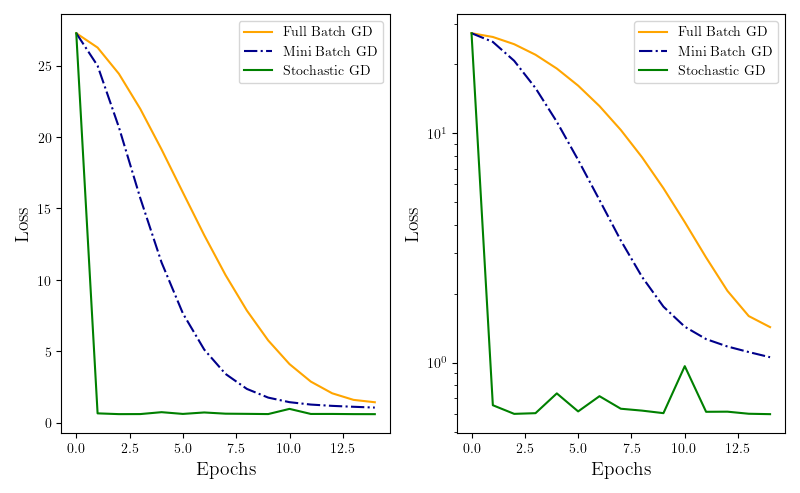

In [38]:
fig, ax = plt.subplots(1,2)

for j in range(2):
    for i in range(3):
        ax[j].plot(losses_gdf1[i],label=text[i],c=colors[i],ls=ls[i])
    ax[j].set_xlabel("Epochs")
    ax[j].set_ylabel("Loss")
    ax[j].legend()

ax[1].set_yscale('log')

plt.show()

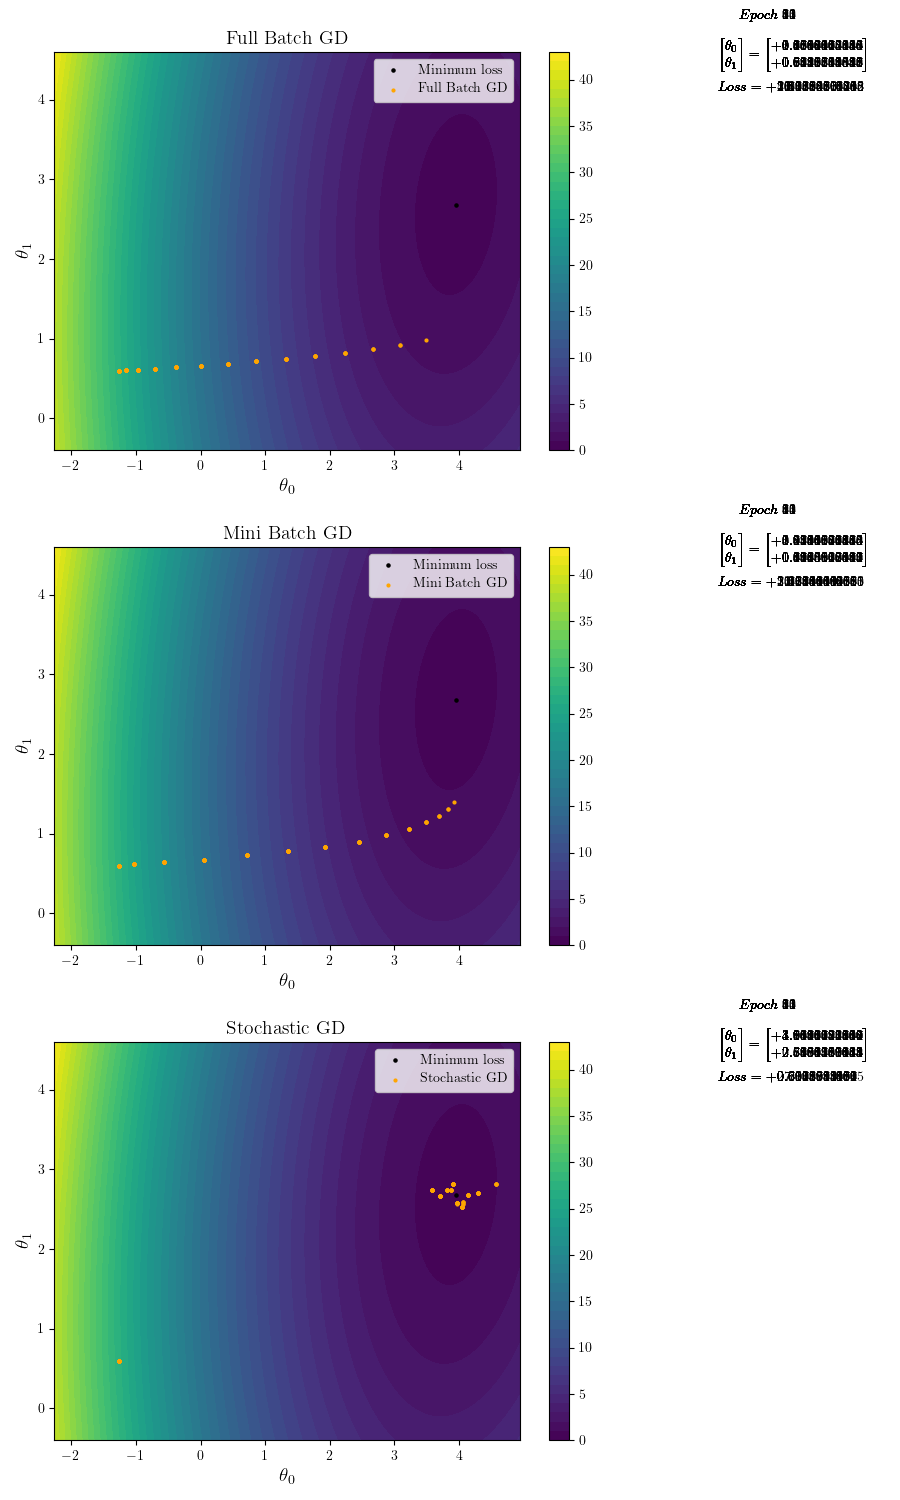

In [44]:
%matplotlib widget

artists = []
ans = []
fig, ax = plt.subplots(3,1,figsize=(9,15))
for i in range(3):
    cs = ax[i].contourf(x,y,z,50,cmap=colormaps['viridis'])
    plt.colorbar(cs)
    
    ax[i].set(title=text[i],xlabel="$\\theta_0$",ylabel="$\\theta_1$")
    ax[i].scatter(opt_theta[0].item(),opt_theta[1].item(),c='k',s=5,label="Minimum loss")
    ax[i].scatter([],[],c ='orange',s=4,label=text[i])
    ax[i].legend()

    artists.append([])

    for j in range(len(thetas_gdf1[i])):
        artists[i].append([
            ax[i].scatter(thetas_gdf1[i][:j,0],thetas_gdf1[i][:j,1],c ='orange',s=4),
            ax[i].text(8,5,
            fr"""$Epoch\ {j+1} \\ \\ \begin{{bmatrix}} \theta_0 \\ \theta_1\end{{bmatrix}} = \begin{{bmatrix}}{thetas_gdf1[i][j,0]:<+5.10f}\\{thetas_gdf1[i][j,1]:<+5.10f}\end{{bmatrix}}\\ \\ Loss = {losses_gdf1[i][j]:+5.10f}$"""
            )
        ])
    ans.append(animation.ArtistAnimation(fig=fig, artists=artists[i], interval=500,repeat=True))

plt.show()